In [2]:
  !pip install lightning-bolts pytorch-lightning

In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
from pl_bolts.models.autoencoders import VAE
from torchvision import datasets, transforms
from pytorch_lightning import Trainer
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from PIL import Image
import numpy as np

In [3]:
class PerturbCIFAR10(datasets.CIFAR10):
    def __init__(
            self,
            root,
            train = True,
            orig_transform = None,
            perturb_transform = None,
            target_transform = None,
            download = False,
    ):
        super().__init__(root=root, train=train, transform=perturb_transform, target_transform=target_transform, download=download)
        self.orig_transform = orig_transform

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)

        if self.transform is not None:
            img_perturb = self.transform(img)
          
        if self.orig_transform is not None:
            img = self.orig_transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, img_perturb, target

In [4]:
class botlessCIFAR10(datasets.CIFAR10):
    def __init__(
            self,
            root,
            train = True,
            transform = None,
            target_transform = None,
            download = False,
    ):
        super().__init__(root=root, train=train, transform=transform, target_transform=target_transform, download=download)
        self.orig_transform = orig_transform

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)
        

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, img_botless, target

In [5]:
class JigsawPuzzleTransform:
    def __init__(self):
        # self.sample = x
        pass

    def __call__(self, sample):
        five_cropped = transforms.FiveCrop(size=(16, 16))
        five_c = list(five_cropped(sample))
        # print("five_c[0].shape",five_c[0].shape)
        five_c = five_c[:-1]
        np.random.shuffle(five_c)
        puzzled = torch.zeros((3, 32, 32))
        puzzled[:, 0:16, 0:16] = five_c[0]
        puzzled[:, 16:32, 0:16] = five_c[1]
        puzzled[:, 0:16, 16:32] = five_c[2]
        puzzled[:, 16:32, 16:32] = five_c[3]
        # print("five_c len",len(five_c))
        
        # puzzled = torch.cat(five_c, 1)
        # print(puzzled.shape)

        return puzzled
  

In [6]:
class GaussianNoise:
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(
    #     mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
    #     std=[x / 255.0 for x in [63.0, 62.1, 66.7]],
    # )
])

grayscale_transform = transforms.Compose([
    transform,
    transforms.Grayscale(3)
])

# noise
gaussianNoise_transform = transforms.Compose([
    transform,
    GaussianNoise(0., 0.06)
])

#jigsaw_puzzle
puzzle_transform = transforms.Compose([
    transform,
    JigsawPuzzleTransform()
])

# Gray Scaled batch

In [ ]:
batch_size=256

trainset = PerturbCIFAR10(root='./data', train=True,
                          download=True, orig_transform=transform, perturb_transform=grayscale_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=8)

testset = PerturbCIFAR10(root='./data', train=False,
                         download=True, orig_transform=transform, perturb_transform=grayscale_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=8)

  0%|          | 0/170498071 [00:00<?, ?it/s]

# Gaussian Noise added batch

In [13]:
batch_size=256

trainset = PerturbCIFAR10(root='./data', train=True,
                          download=True, orig_transform=transform, perturb_transform=gaussianNoise_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=8)

testset = PerturbCIFAR10(root='./data', train=False,
                         download=True, orig_transform=transform, perturb_transform=gaussianNoise_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=8)

Files already downloaded and verified
Files already downloaded and verified


# Jigsaw Puzzled batch

In [ ]:
batch_size=256

trainset = PerturbCIFAR10(root='./data', train=True,
                          download=True, orig_transform=transform, perturb_transform=puzzle_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=8)

testset = PerturbCIFAR10(root='./data', train=False,
                         download=True, orig_transform=transform, perturb_transform=puzzle_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=8)

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified


In [14]:
x, x_perturb, y = next(iter(trainloader))
print(x.shape, x_perturb.shape, y.shape)

torch.Size([256, 3, 32, 32]) torch.Size([256, 3, 32, 32]) torch.Size([256])


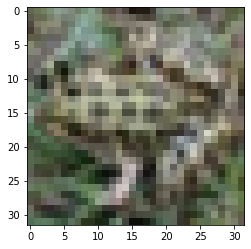

In [15]:
plt.imshow(x[0].permute(1, 2, 0).detach().cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


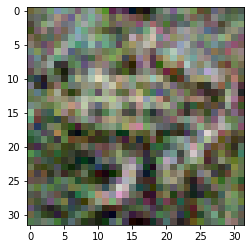

In [16]:
plt.imshow(x_perturb[0].permute(1, 2, 0).detach().cpu())

In [17]:
class PerturbVAE(VAE):
    def step(self, batch, batch_idx):
        x_orig, x_perturb, y = batch
        z, x_hat, p, q = self._run_step(x_perturb)

        recon_loss = F.mse_loss(x_hat, x_orig, reduction='mean')

        log_qz = q.log_prob(z)
        log_pz = p.log_prob(z)

        kl = log_qz - log_pz
        kl = kl.mean()
        kl *= self.kl_coeff

        loss = kl + recon_loss

        logs = {
            "recon_loss": recon_loss,
            "kl": kl,
            "loss": loss,
        }
        return loss, logs

In [18]:
model = PerturbVAE(enc_type='resnet18', input_height=32)
# model = PerturbVAE(input_height=32).from_pretrained('cifar10-resnet18')

In [19]:
trainer = Trainer(gpus=1, max_epochs=30)
trainer.fit(model, train_dataloader=trainloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/home/alireza/miniconda3/envs/maedeh/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: you defined a validation_step but have no val_dataloader. Skipping val loop
  warnings.warn(*args, **kwargs)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name    | Type          | Params
------------------------------------------
0 | encoder | ResNetEncoder | 11.2 M
1 | decoder | ResNetDecoder | 8.6 M 
2 | fc_mu   | Linear        | 131 K 
3 | fc_var  | Linear        | 131 K 
------------------------------------------
20.1 M    Trainable params
0         Non-trainable params
20.1 M    Total params
80.228    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/home/alireza/miniconda3/envs/maedeh/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


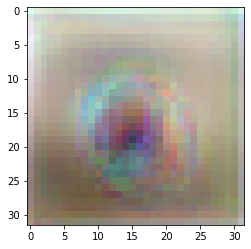

In [20]:
plt.imshow(model(x_perturb[:1]).squeeze().permute(1, 2, 0).detach().cpu())

# Linear Classification

In [23]:
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

In [25]:
latent = []
labels = []
for idx, (x, x_perturb, y) in enumerate(tqdm(trainloader)):
#     z, x_hat, p, q = model._run_step(x_perturb)
    x = model.encoder(x)

    mu = model.fc_mu(x)

    log_var = model.fc_var(x)

    p, q, z = model.sample(mu, log_var)
    
    z=z.detach().cpu().numpy()
    latent.append(z)
    labels.append(y)
# x, x_perturb, y = next(iter(trainloader))

100%|██████████| 196/196 [03:55<00:00,  1.20s/it]


In [26]:
z = np.concatenate(latent)

In [27]:
y = np.concatenate(labels)

In [28]:
clf = LogisticRegression(random_state=0, max_iter=5000).fit(z, y)

In [29]:
clf.score(z, y)

0.2675

In [30]:
latent2 = []
labels2 = []
for idx, (x, x_perturb, y) in enumerate(tqdm(testloader)):
#     z, x_hat, p, q = model._run_step(x_perturb)
    x = model.encoder(x)

    mu = model.fc_mu(x)

    log_var = model.fc_var(x)

    p, q, z = model.sample(mu, log_var)
    
    z=z.detach().cpu().numpy()
    latent2.append(z)
    labels2.append(y)

100%|██████████| 40/40 [00:56<00:00,  1.42s/it]


In [33]:
z = np.concatenate(latent2)

In [34]:
y = np.concatenate(labels2)

In [35]:
clf = LogisticRegression(random_state=0, max_iter=5000).fit(z, y)

In [36]:
clf.score(z, y)

0.3196